In [2]:
%%capture
%cd $PROJECT_DIR

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.data.utils import get_csv_converters

In [4]:
df = pd.read_csv('./data/clean/clean.csv', converters=get_csv_converters())

/var/folders/39/7p_9gmm53l15x4p__jk4rxxr0000gn/T/ipykernel_36727/3215383916.py:1: DtypeWarning: Columns (10,12,33) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./data/clean/clean.csv', converters=get_csv_converters())


In [5]:
# Encode and convert to PCA for visualisation.
from src.data.feature_processors.list_processor import ListProcessor
from sklearn.decomposition import PCA

fp = ListProcessor('skills')
skills_df = fp.process(df[['skills']])

pca = PCA(n_components=2)  # Reduce to 2 components for visualization
pca_result = pca.fit_transform(skills_df)

# Create a DataFrame for the PCA result
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])

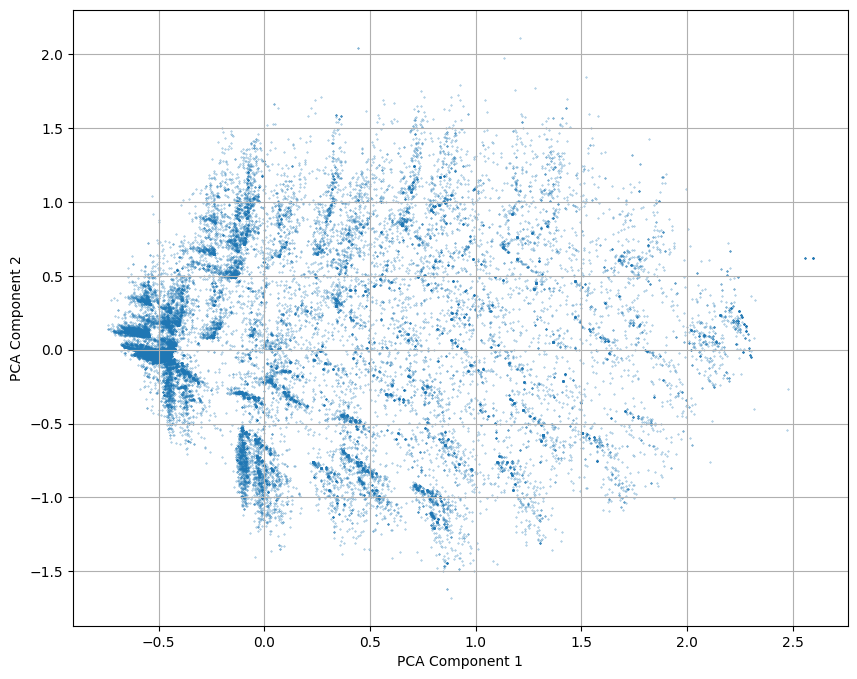

In [8]:
# Plot the  PCA space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    pca_df['PCA1'], 
    pca_df['PCA2'], 
    # cmap='tab10', 
    alpha=0.7, 
    s=.1
)
# plt.colorbar(scatter, label='Cluster Label')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.grid(True)
plt.show()

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation


In [59]:
# Filter out rows with empty skills
train_df = df[df['skills'].apply(bool)]  # Keep rows where 'skills' is not an empty list

In [60]:
# Example: df['skills'] is a column containing lists of skills
# Convert lists of skills into space-separated strings for each row
unique_skills = set([skill.lower() for skills in train_df['skills'] for skill in skills])
unique_additional_skills = set([skill.lower() for skills in train_df['additional_skills'] for skill in skills])
all_skills = unique_skills | unique_additional_skills

# Transform the textual data into a Document-Term Matrix
vectorizer = CountVectorizer(vocabulary=all_skills)
dtm_skills = vectorizer.fit_transform(train_df['skills'].apply(lambda x: ' '.join(x)))
dtm_additional_skills = vectorizer.fit_transform(train_df['skills'].apply(lambda x: ' '.join(x)))

# Combine the vectors with the specified weight
dtm = dtm_skills + 0.5 * dtm_additional_skills

In [61]:
# Evaluate perplexity for different numbers of topics
perplexities = []

for n_topics in range(2, 51):
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, max_iter=10, learning_method='online')
    lda.fit(dtm)
    perplexities.append(lda.perplexity(dtm))

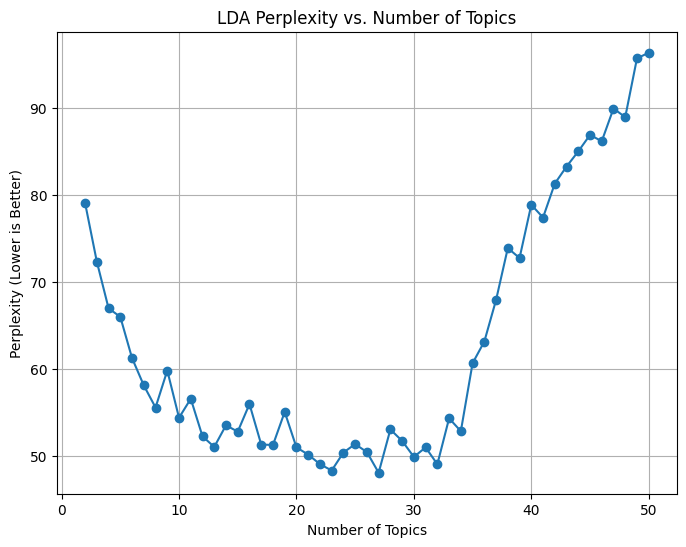

In [62]:
# Plot perplexity vs. number of topics
plt.figure(figsize=(8, 6))
plt.plot(range(2, len(perplexities) + 2), perplexities, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity (Lower is Better)')
plt.title('LDA Perplexity vs. Number of Topics')
plt.grid(True)
plt.show()

In [65]:
optimal_n_topics = range(2, 51)[np.argmin(perplexities)]
print(f"Optimal number of topics: {optimal_n_topics}")

Optimal number of topics: 27


In [66]:
# Assuming skills_df is your high-dimensional feature matrix
# Fit LDA to extract latent topics
n_topics = optimal_n_topics  # Define the number of topics (clusters) to extract
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_result = lda.fit_transform(dtm)  # Each row gives topic distribution for a sample


# Add topic labels based on the dominant topic for each sample
train_df['LDA_Topic'] = lda_result.argmax(axis=1)

/var/folders/39/7p_9gmm53l15x4p__jk4rxxr0000gn/T/ipykernel_36727/2849875394.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['LDA_Topic'] = lda_result.argmax(axis=1)


/var/folders/39/7p_9gmm53l15x4p__jk4rxxr0000gn/T/ipykernel_36727/1583485003.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pca_df['LDA_Topic'] = train_df['LDA_Topic']


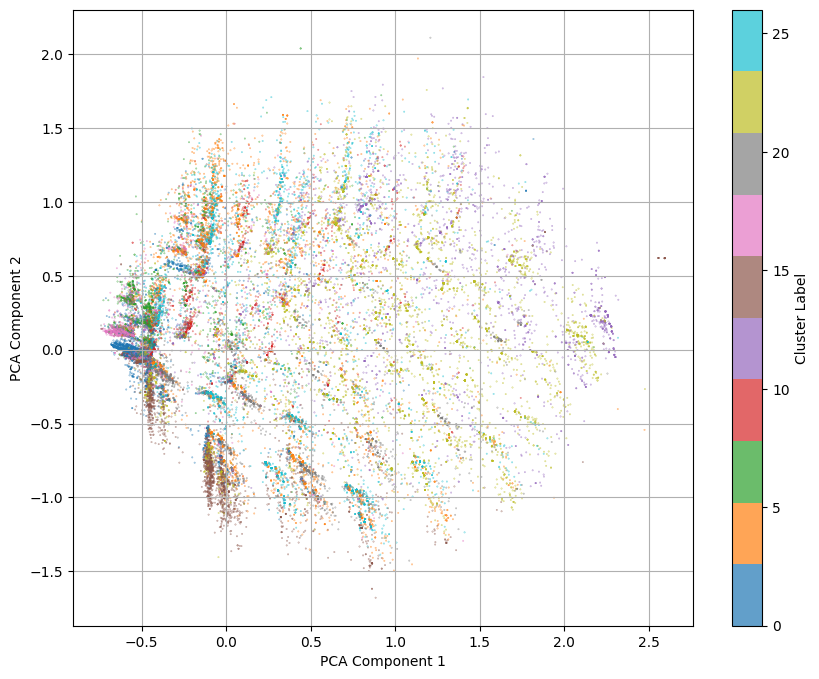

In [67]:
# Add the cluster labels to the PCA DataFrame
pca_df = pca_df[df['skills'].apply(bool)]
pca_df['LDA_Topic'] = train_df['LDA_Topic']

# Plot the OPTICS results in PCA space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    pca_df['PCA1'], 
    pca_df['PCA2'], 
    c=pca_df['LDA_Topic'], 
    cmap='tab10', 
    alpha=0.7, 
    s=.1
)
plt.colorbar(scatter, label='Cluster Label')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
# plt.title('LDA Clustering Visualization in PCA Space')
plt.grid(True)
plt.show()

In [77]:
# Combine into a single DataFrame for better readability
pd.DataFrame({
    'Raw Count': train_df['LDA_Topic'].value_counts(),
    'Normalized Count': train_df['LDA_Topic'].value_counts(normalize=True),
})


,Raw Count,Normalized Count
LDA_Topic,,
0,5174,0.111221
23,3402,0.073130
26,2899,0.062317
20,2403,0.051655
12,2201,0.047313
17,2148,0.046174
25,2086,0.044841
21,2064,0.044368
13,2035,0.043745


In [75]:
# Number of top tokens to display per topic
n_top_tokens = 10

# Get the feature names (tokens) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Display the most common tokens for each LDA topic
for topic_idx, topic_weights in enumerate(lda.components_):
    print(f"Stack {topic_idx}:")
    top_tokens = [feature_names[i] for i in topic_weights.argsort()[:-n_top_tokens - 1:-1]]
    print(", ".join(top_tokens))
    print("-" * 40)

Stack 0:
android, ios, smartphone, flutter, firebase, kotlin, java, dart, tablet, swift
----------------------------------------
Stack 1:
sql, database, server, dns, migration, oracle, firewall, directory, vpn, cloudflare
----------------------------------------
Stack 2:
application, voip, flask, fastapi, sqlite, communications, electron, asterisk, graph, webrtc
----------------------------------------
Stack 3:
javascript, api, php, java, golang, python, sap, gis, arcgis, godot
----------------------------------------
Stack 4:
mongodb, postgresql, api, javascript, react, expressjs, ruby, graphql, database, nestjs
----------------------------------------
Stack 5:
website, webflow, wix, animation, squarespace, wordpress, blog, front, godaddy, migration
----------------------------------------
Stack 6:
automation, chatbot, zapier, scripting, script, basic, bot, airtable, business, tradingview
----------------------------------------
Stack 7:
api, salesforce, chatgpt, sales, twilio, implem

In [72]:
train_df[train_df['LDA_Topic'] == 0]['skills']


14       [React Native, Smartphone, Android, iOS, iOS D...
32         [Microsoft PowerApps, Microsoft Power Automate]
40              [Web Design, Graphic Design, Landing Page]
70       [API Integration, Dart, Software Debugging, SD...
71       [Android, Android App Development, Mobile App ...
                               ...                        
47138      [Flutter, iOS, Android, Mobile App Development]
47169    [Troubleshooting, Technical Support, iOS, Smar...
47170        [Data Scraping, Microsoft Excel, Data Mining]
47197    [iOS, Android App Development, Flutter, iOS De...
47222                                         [Web Design]
Name: skills, Length: 5174, dtype: object

In [73]:
train_df[train_df['LDA_Topic'] == 1]['skills']

24       [MySQL, MySQL Programming, Database Management...
78       [Web Application, Database Development, Full-S...
97       [Azure DevOps, Database, Database Maintenance,...
103      [Windows Server, Microsoft Hyper-V Server, Bac...
105      [Windows Server, Windows Administration, Syste...
                               ...                        
47119    [Office 365, Microsoft Outlook, Microsoft Exch...
47129           [Email Deliverability, SendGrid, DNS, API]
47176                                [Database, WordPress]
47192    [DNS, System Administration, Email Support, Mi...
47210               [Python, SQL, Data Science, Snowflake]
Name: skills, Length: 1513, dtype: object

In [91]:
# Set the threshold for topic assignment
threshold = 0.3  # Adjust this value as needed

# Create a custom topic label based on the threshold
def assign_topic_with_threshold(lda_result, threshold):
    max_probs = lda_result.max(axis=1)  # Maximum probability for each sample
    labels = lda_result.argmax(axis=1)  # Dominant topic for each sample
    labels[max_probs < threshold] = -1  # Assign -1 to samples below the threshold
    return labels

# Apply the threshold-based labeling
train_df['LDA_Topic'] = assign_topic_with_threshold(lda_result, threshold)
pca_df['LDA_Topic'] = train_df['LDA_Topic']

/var/folders/39/7p_9gmm53l15x4p__jk4rxxr0000gn/T/ipykernel_36727/1970126203.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['LDA_Topic'] = assign_topic_with_threshold(lda_result, threshold)
/var/folders/39/7p_9gmm53l15x4p__jk4rxxr0000gn/T/ipykernel_36727/1970126203.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pca_df['LDA_Topic'] = train_df['LDA_Topic']


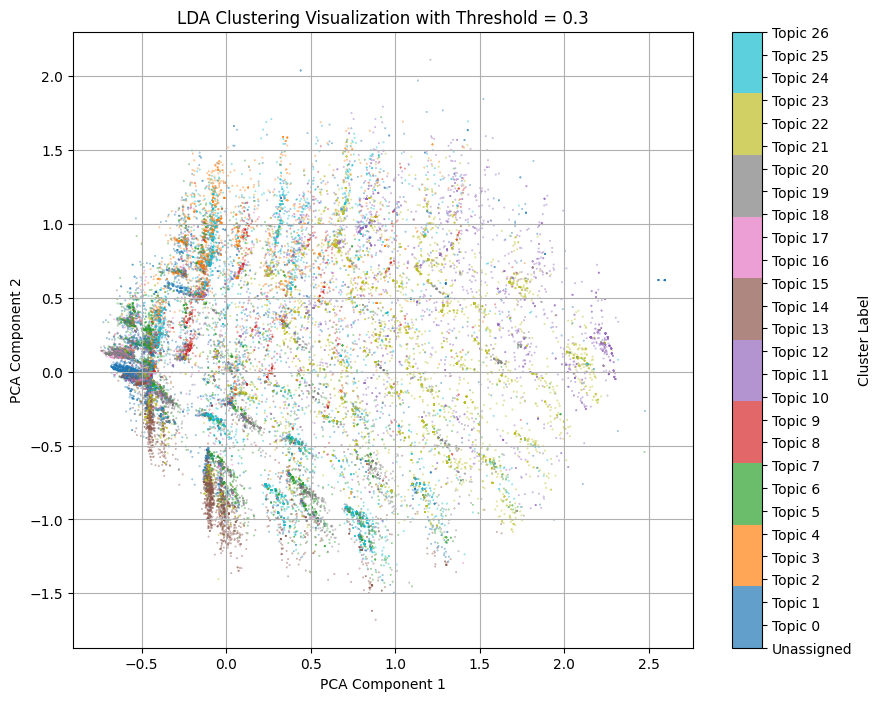

In [92]:
# Visualize the results in PCA space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    pca_df['PCA1'], 
    pca_df['PCA2'], 
    c=pca_df['LDA_Topic'], 
    cmap='tab10', 
    alpha=0.7, 
    s=0.1,
    vmin=-1  # Ensure -1 is properly mapped
)

# Add a custom color for topic -1 (black)
cbar = plt.colorbar(scatter, label='Cluster Label')
cbar.set_ticks(range(-1, lda.n_components))  # Include -1 in the colorbar ticks
cbar.ax.set_yticklabels(['Unassigned' if t == -1 else f'Topic {t}' for t in range(-1, lda.n_components)])

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title(f'LDA Clustering Visualization with Threshold = {threshold}')
plt.grid(True)
plt.show()

In [93]:
train_df['LDA_Topic'].value_counts(normalize=True)

LDA_Topic
-1     0.108684
 23    0.070249
 26    0.061780
 20    0.050494
 0     0.048431
 12    0.046561
 17    0.044647
 21    0.043401
 13    0.042691
 25    0.042046
 18    0.037898
 5     0.035985
 15    0.035705
 7     0.034286
 6     0.031965
 19    0.030825
 1     0.029794
 3     0.028117
 22    0.027601
 16    0.025688
 9     0.022614
 24    0.019368
 4     0.019347
 11    0.018616
 10    0.011371
 8     0.011371
 14    0.010340
 2     0.010125
Name: proportion, dtype: float64

In [94]:
train_df[train_df['LDA_Topic'] == -1]['skills']


8        [Mockup, Website Redesign, Figma, CSS, HTML, S...
29       [Squarespace, Amazon Plugin, Web Design, Web D...
32         [Microsoft PowerApps, Microsoft Power Automate]
40              [Web Design, Graphic Design, Landing Page]
47       [GitLab, Web Application, JavaScript, MySQL, R...
                               ...                        
47170        [Data Scraping, Microsoft Excel, Data Mining]
47184    [Web Development, HTML, PHP, Zapier, Shopify, ...
47195    [Web Design, HTML, Web Development, Landing Pa...
47217    [Web Development, Web Design, PHP, JavaScript,...
47222                                         [Web Design]
Name: skills, Length: 5056, dtype: object